# HW1: Reconstruction of 2D-CT images
_Luke Doladille  
Oct. 10, 2025_

## Brief introduction and notations

The principle of a CT scan is to take X-rays of a TO (therapeutic object) at all angles $\theta \in [0,\pi]$, and then to reconstruct an image of the TO using a computational approach.

X-rays are emitted towards the TO with an **initial intensity $I_0$** along a line forming an angle $\theta$ with the x-axis.  
The detector detects the **final intensity $I_d$** after attenuation through the TO.  
Let $f$ be the **absorption function**, which we will consider equal to the image grayscale.    
Along the detector's line, perpendicular to the emitted X-rays, we can rewrite the absorption profile by using the Radon Transform: 

\begin{equation}
g(l,\theta) = log(\frac{I_0}{I_d}) \ \ \ \\  
= \int_{L(l,\theta)} f(x(s), y(s)) ds \ \ \ \\ 
= \int \int_{\mathbf{R^2}} f(x,y) \ \delta(l - x \cos\theta - y \sin\theta) \ dxdy \ \ \ \\
\end{equation}

$(1)$ is derived from the Beer-Lambert law.   

This equation is the starting point for the **Fourier method**, which relies on the **Projection-Slice theorem**.  
However, a more common and computationally efficient approach is the **Filtered Back Projection method**.

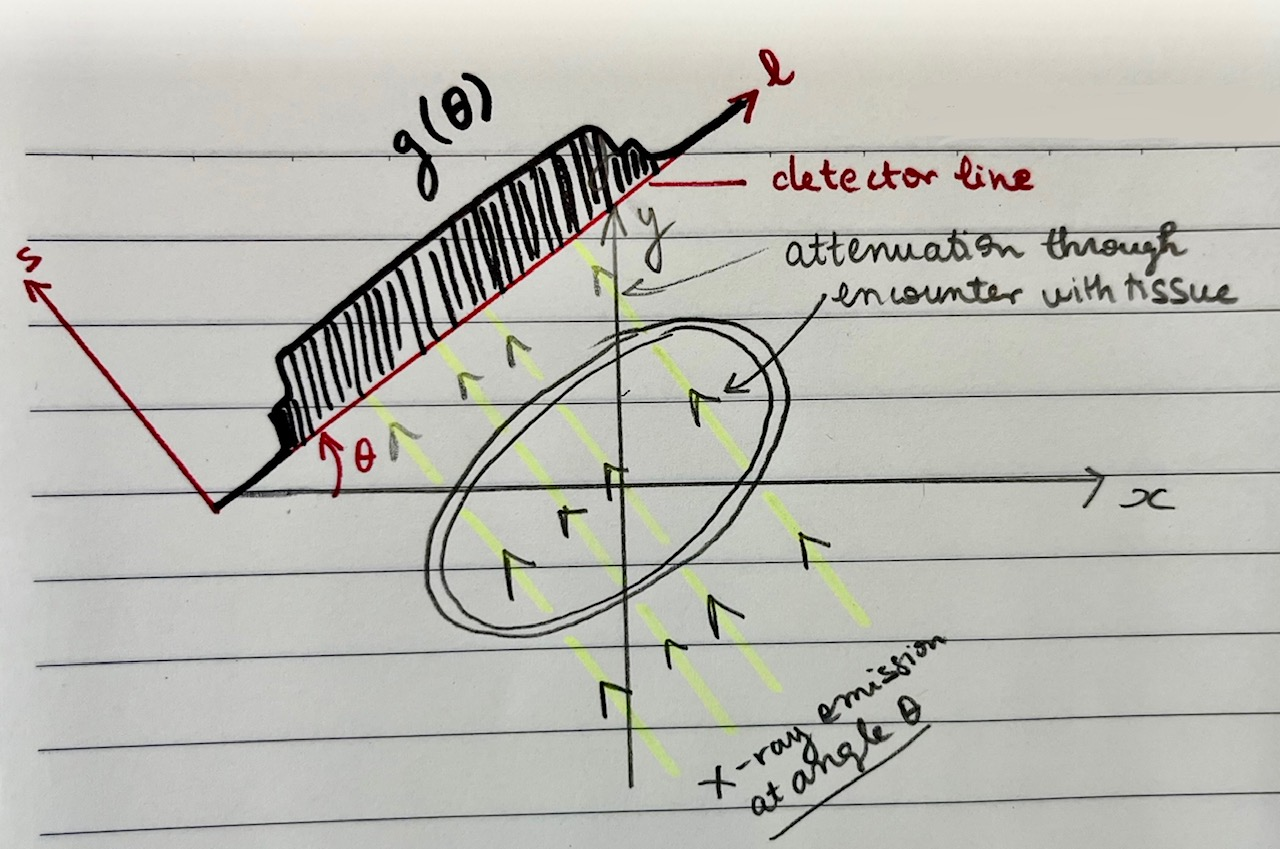


## 1. Computing the sinogram from the grayscale image based on a given angle set

In the normal order of a CT scan, we would use $g(l,\theta)$ to compute the absorption function $f(x,y)$.  
In this exercise however, we are given $f(x,y)$ with the picture's grayscale: we will use our knowledge of $f(x,y)$ to compute the sinogram $g(l,\theta)$ step by step.  
According to the Radon Transform, the value at the point $(l,\theta)$ of the sinogram is the sum of all pixel intensities for pixels verifying $l = x \cos\theta + y \sin\theta$ 

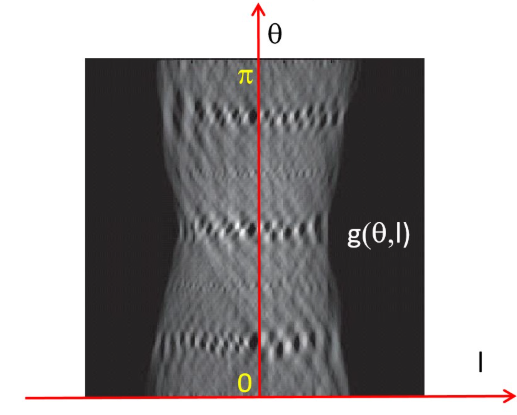

### Preliminary: Import useful libraries for graphic interface and practical computing 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rescale
from skimage import io 

The three following steps were implemented in the function "compute_sinogram_manual", which takes an image as an input.  

### Step 1: Initializing the sinogram

First we create a **2D array of zeroes** to initalize the sinogram.  
- For the $\theta$ axis, we must fix a set of angles corresponding to horizontal projection lines (red line on drawing). I chose the interval $[0°,180°]$ with a $1°$ step.  
- For the $l$ axis, we must choose values of $l$ which include the longest projection line possible: the image's diagonal.

### Step 2: Centering the coordinates' origin

Usually, the image's origin $(0,0)$ of coordinates is at the top-left corner. We must **center the origin** as it is done in the theoretical introduction. 

### Step 3: Computing the sinogram array 

To compute the sinogram array, we implemented **two imbricated loops**:
1. We iterate over **all $(i,j)$ pixels** of the input image; 
2. Then, for each pixel, we iterate over **all the values of the projection angles $\theta$**;
3. We **transform the image coordinates** $(i,j)$ to place them in a **Cartesian coordinate system**: $x=j-\frac{w}{2}$ and $y=\frac{h}{2}-i$, with $w$ the width of the image and $h$ its height;
4. We **plug-in $x,y, \theta$** into the equation $l = x \cos\theta + y \sin\theta$ **to find the $l$ coordinate**. 
5. Finally, in the sinogram array, we **add the pixel's intensity at the sinogram's $(l, θ)$ point**. 

In [3]:
def compute_sinogram_manual(image):
    
    # STEP 1
    angles = np.linspace(0., 180., 180, endpoint=False) # Chosen set of angles
    imdiag = int(np.ceil(np.sqrt(image.shape[0]**2 + image.shape[1]**2)))
    sinogram = np.zeros((imdiag, len(angles)))
    
    # Pre-calculate cosines and sines for speed
    cos_angles = np.cos(np.deg2rad(angles))
    sin_angles = np.sin(np.deg2rad(angles))
    
    # STEP 2
    center_x = image.shape[1] / 2
    center_y = image.shape[0] / 2
    
    # STEP 3
    # Get pixel coordinates and values
    y_coords, x_coords = np.nonzero(image)
    pixel_values = image[y_coords, x_coords]
    
    for i in range(len(x_coords)):
        px_val = pixel_values[i]
        
        # Translate to centered coordinates
        x = x_coords[i] - center_x
        y = center_y - y_coords[i] # y-vector is pointing upwards, not downwards
        
        for angle_idx, (cos_a, sin_a) in enumerate(zip(cos_angles, sin_angles)):
            # Calculate 'l' for this pixel and this angle
            l = x * cos_a + y * sin_a
            
            # Find the closest detector bin 'l_idx'
            # We shift 'l' by imdiag/2 to fit into the array indices [0, imdiag-1]
            l_idx = int(round(l + imdiag / 2))
            
            # Add pixel intensity to the sinogram bin
            if 0 <= l_idx < imdiag:
                sinogram[l_idx, angle_idx] += px_val
                
    return sinogram

Image n°1 processed!
Image n°2 processed!
Image n°3 processed!


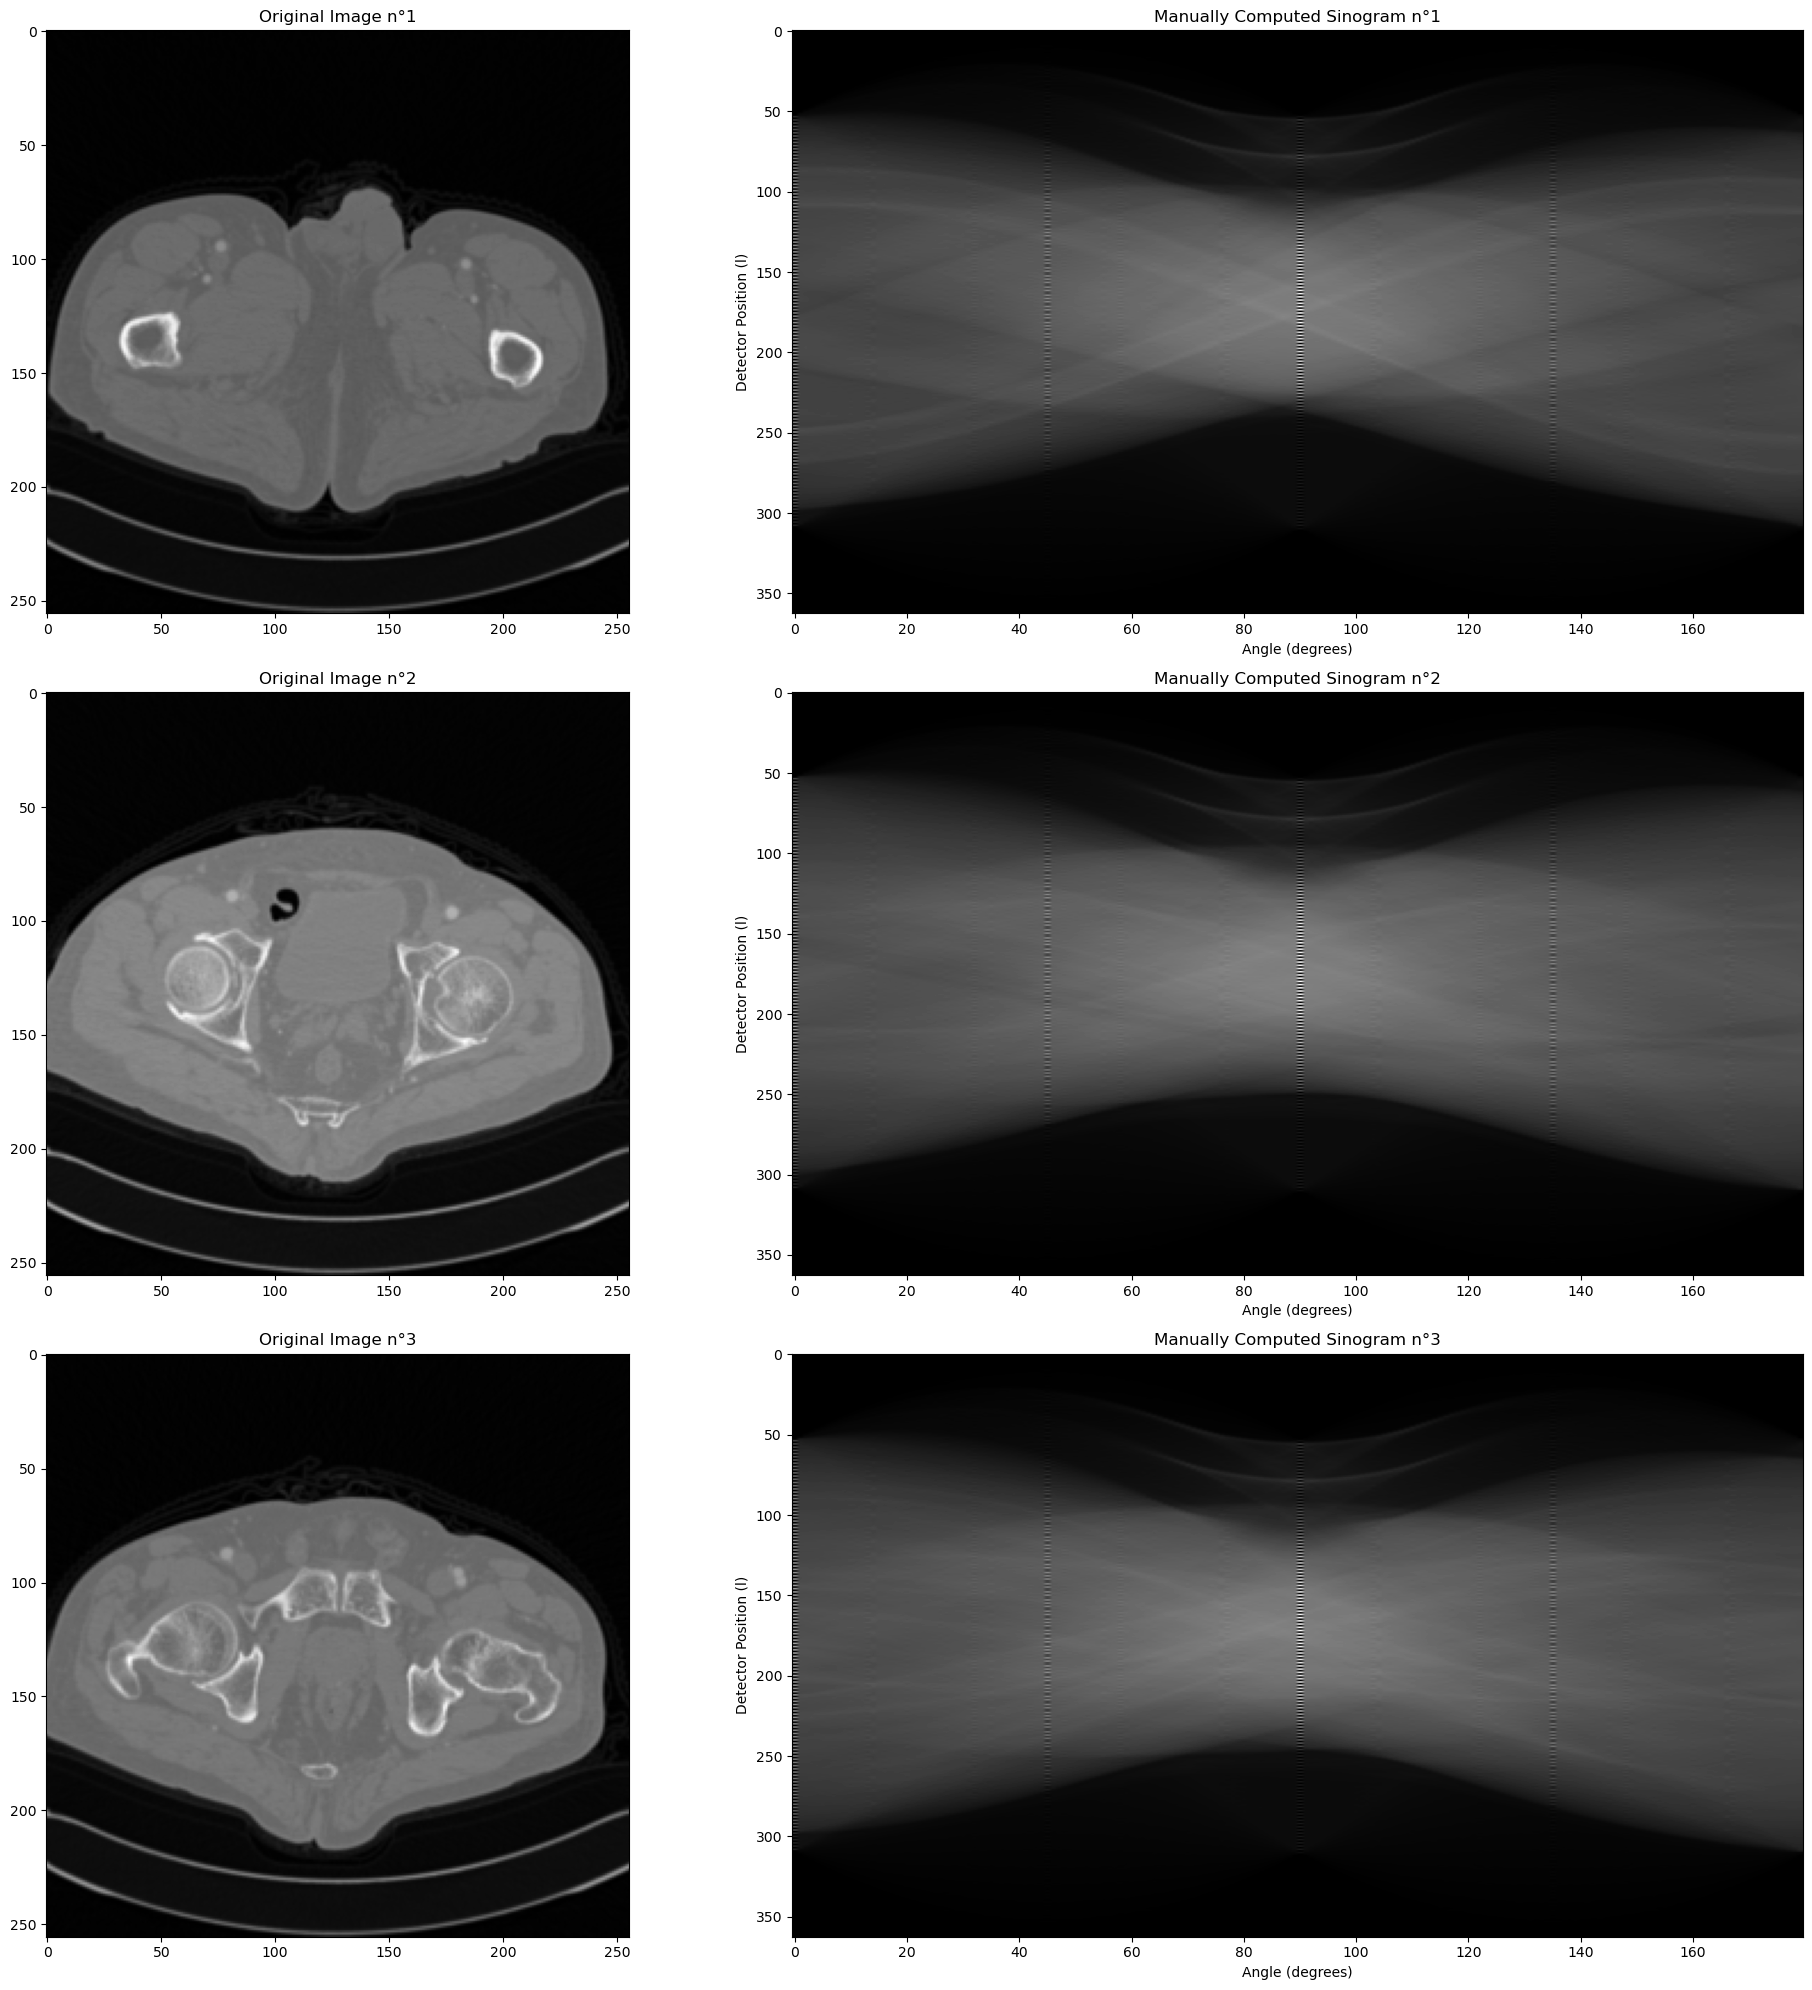

In [20]:
# --- Test of the implementation on the three images ---

# Creates a single figure before the loop
plt.figure(figsize=(20, 20))

for i in range(3): 
    
    file_path = "CTSlice-"+str(i+1)+".png"
    import_image = io.imread(file_path, as_gray=True)
    ctscan = rescale(import_image, scale=0.5, mode='reflect', anti_aliasing=True)

    manual_sinogram = compute_sinogram_manual(ctscan)

    plt.subplot(3, 2, 2 * (i+1) - 1)
    plt.imshow(ctscan, cmap='gray')
    plt.title("Original Image n°"+str(i+1))

    plt.subplot(3, 2, 2 * (i+1))
    plt.imshow(manual_sinogram, cmap='gray', aspect='auto')
    plt.title("Manually Computed Sinogram n°" + str(i+1))
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Detector Position (l)")
    print("Image n°"+str(i+1)+" processed!")

plt.tight_layout()
plt.show()

For comparison, we generated the three sinograms with the **built-in radon function** from the **skimage** library. 

<Figure size 4000x2000 with 0 Axes>

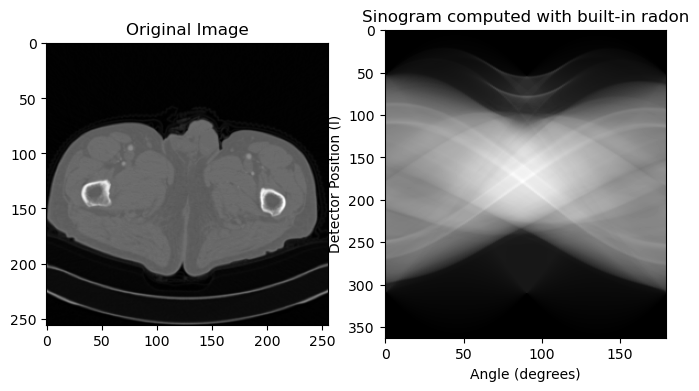

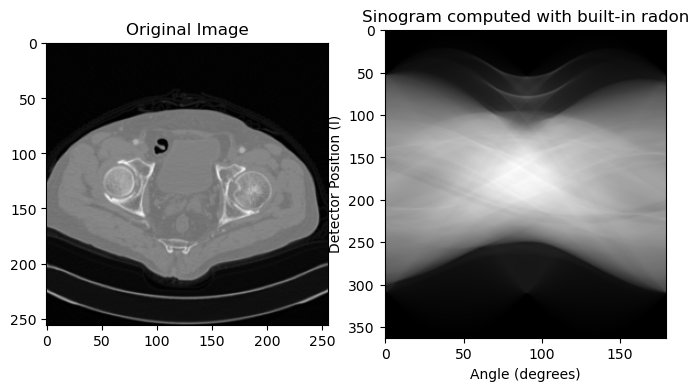

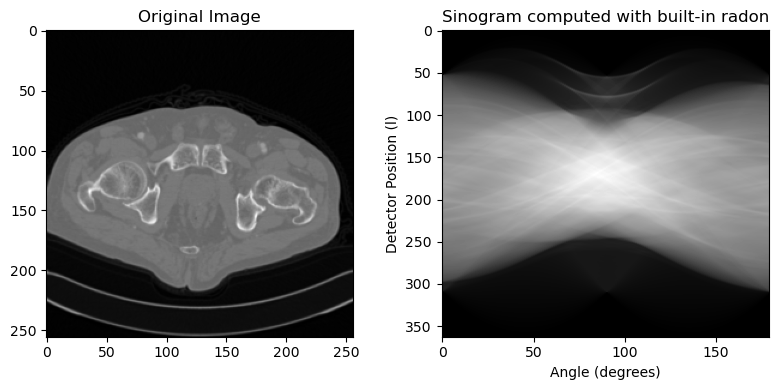

In [4]:
from skimage.transform import radon

# Creates a single figure before the loop
plt.figure(figsize=(40, 20))

for i in range(3): 
    
    file_path = "CTSlice-"+str(i+1)+".png"
    custom_image = io.imread(file_path, as_gray=True)
    ctscan = rescale(custom_image, scale=0.5, mode='reflect', anti_aliasing=True)
    
    # This line replaces the entire manual function
    library_sinogram = radon(ctscan, theta=np.linspace(0., 180., 180, endpoint=False), circle=False)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(ctscan, cmap='gray')
    plt.title("Original Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(library_sinogram, cmap='gray', aspect='auto')
    plt.title("Sinogram computed with built-in radon")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Detector Position (l)")

plt.tight_layout()
plt.show()

### Conclusion to Part 1

As expected, the **manual implementation of the sinogram function is less computationally efficient than the built-in radon method**. 

The sinograms obtained with the manual function present computational artefacts. They appear with streaks due to the "closest-neighbor" method used for the detector binning. Indeed, for each pixel from the image, we attribute all of its intensity value to only one coordinate $l$ for each $\theta$ angle. However, for a given projection line $\theta$, the point's $l$ value is seldom an integer, so the intensity value should be shared between the two closest integers. 

On the sinograms obtained with the built-in radon function, there are no artefacts and they appear smooth and clean. 

## 2. Reconstruct the original image from the computed sinogram and the given angle set

**FBP (Filtered back-projection)** relies on the **Slice Projection Theorem**, which states that the 1D Fourier Transform of a projection $R(f)(\rho,\theta)$ at a given angle $\theta$ is equal to the 2D Fourier Transform of the original object $f(x,y)$ evaluated along a radial slice at that same angle $\theta$ in the frequency domain: 

\begin{equation} G(\rho,\theta)=F(\rho \ cos \ \theta, \rho \ sin \ \theta). \end{equation}

Besides the SP Theorem (2), the workflow of FBP is derived from mathematical computations directly on the **2D inverse Fourier transform in polar coordinates**. This allows us to avoid interpolating from a polar grid to a Cartesian one in the frequency domain. 

The steps of FBP are :
1. Take the projections (sinogram) at a set of angles $\theta$ in $[0, \pi]$. 
2. Go to the *frequency domain* with the **1-D Fourier Transform** of those projections : $G(\rho,\theta)=\int_{-\infty}^{+\infty} g(l,\theta) \ e^{-j2\pi pl} dl$ 
3. Perform a filtering with an RL filter in the *frequency domain*: $G(\rho,\theta)*|\rho|$
4. Return to the *spatial domain* by taking the **1-D inverse Fourier Transform** of the previous quantity: $p'(l,\theta) = \int_{-\infty}^{+\infty} |\rho| G(\rho,\theta) e^{j2\pi\rho l}d\rho $ 
5. Perform a back-projection (the value of any pixel (x,y) in the final image is the sum (integral) of the contributions from every filtered projection that passes through that point): $\forall (x,y) \in \mathbf{R^2}, f(x,y) = \int_{0}^\pi p'(l, \theta) d\theta$

The computational obstacle here resides within the last step, with the use of the **back-projection step**, at a $O(N^3)$ complexity. 
Now, we perform the FBP using the iradon function from the Python skimage library.

I initially tried to implement the FBP **without using the inverse Radon transform function (iradon) from skimage**. However, this proved to be highly ineffective, with an extremely high computation time. 

Therefore, for this part, I did not implement back-projection entirely from scratch. I just compared : 
1. **Manual** implementation of the filtering + iradon function with no filtering
2. **Standard** implementation with iradon  

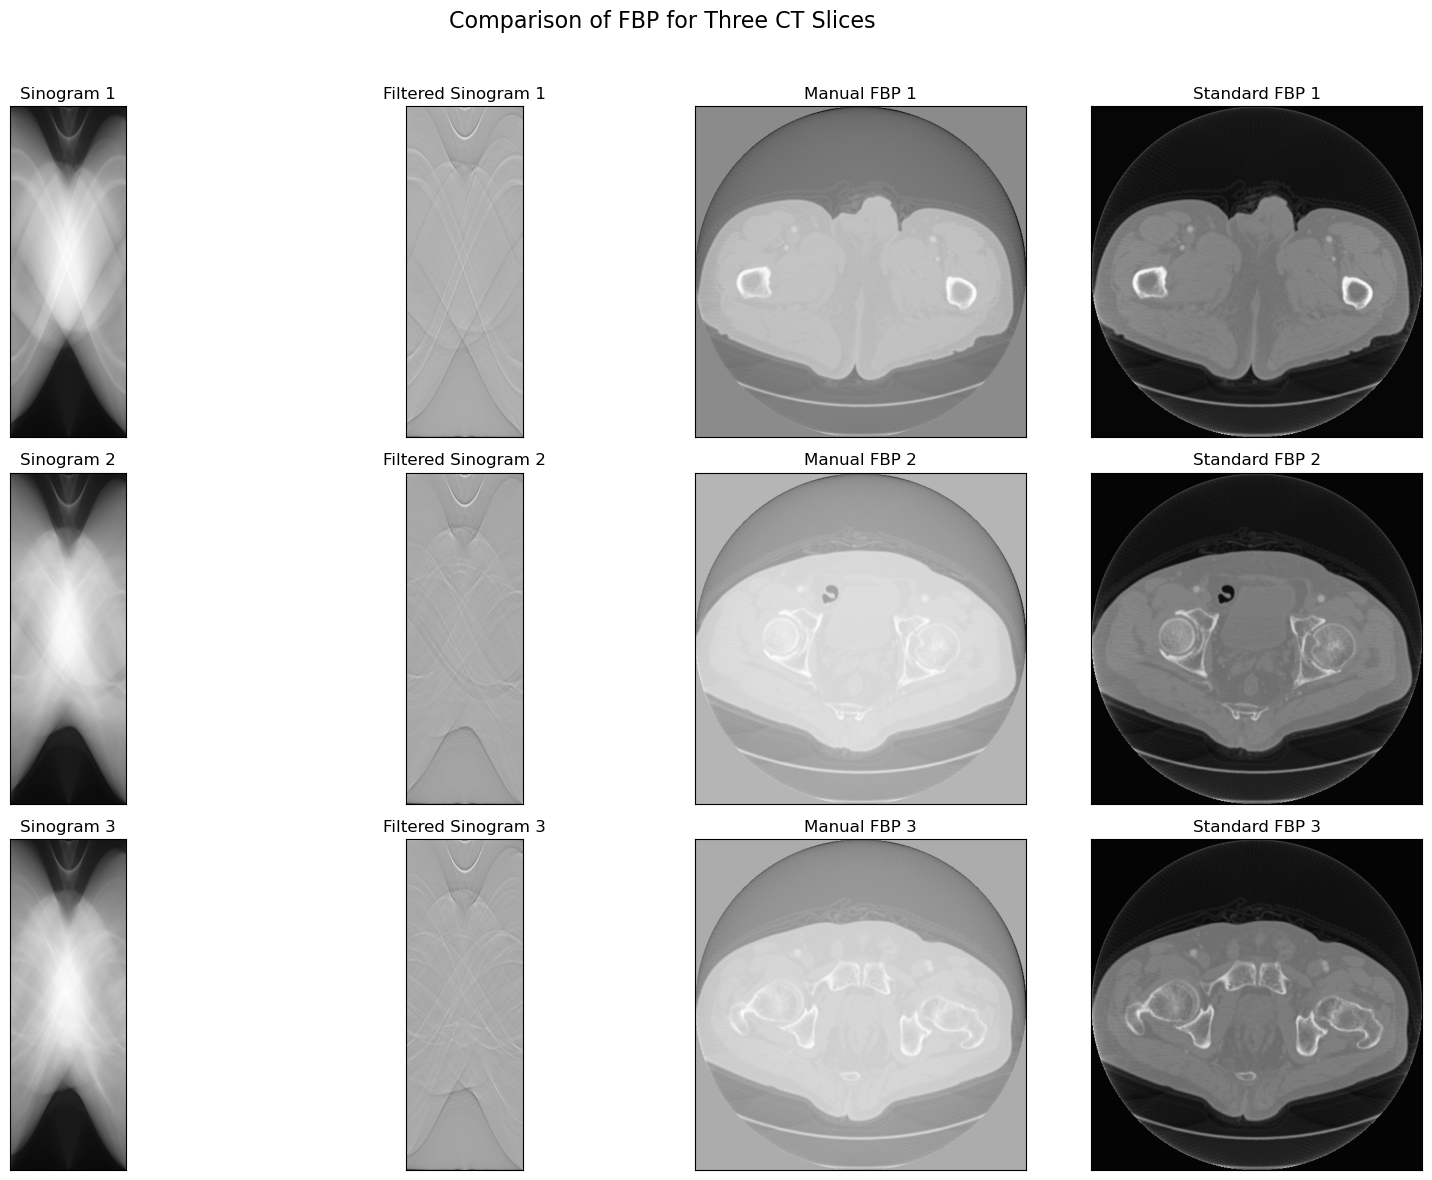

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon

def filter_sinogram(sinogram):
    """
    Applies a RL filter to the sinogram in the frequency domain.
    """
    # Get the number of detector bins (height of the sinogram)
    num_detectors = sinogram.shape[0]
    
    # 1. Create the RL filter in the frequency domain
    # Create a frequency array for the 1D FFT
    # np.fft.fftfreq gives frequency bins: [0, 1/n, 2/n, ..., (n-1)/2n, -(n-1)/2n, ..., -1/n]
    freq = np.fft.fftfreq(num_detectors)
    
    # The RL filter is essentially |f| in the frequency domain.
    # We create a ramp filter that is |freq|.
    rl_filter = np.abs(freq)
    
    # 2. Apply the filter to each projection
    # Take the 1D FFT of each projection (along the detector axis)
    sinogram_fft = np.fft.fft(sinogram, axis=0)
    
    # Multiply the FFT of each projection by the RL filter
    # The filter is 1D, so we need to reshape it to match the broadcasting rules
    filtered_sinogram_fft = sinogram_fft * rl_filter[:, np.newaxis]
    
    # Take the inverse 1D FFT to get the filtered sinogram
    filtered_sinogram = np.fft.ifft(filtered_sinogram_fft, axis=0)
    
    # The result of the IFFT will be complex, so we take the real part
    return filtered_sinogram.real

# --- Test on the three images ---

# Create one large figure with 3 rows and 4 columns
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Comparison of FBP for Three CT Slices', fontsize=16)

for i in range(3): 
    
    file_path = "CTSlice-"+str(i+1)+".png"
    image = io.imread(file_path, as_gray=True)
    
    # 1. Create a sample image and its sinogram
    theta = np.linspace(0., 180., 180, endpoint=False)
    sinogram = radon(image, theta=theta, circle=True)

    # 2. Manually filter the sinogram using our function
    manually_filtered_sinogram = filter_sinogram(sinogram)

    # 3. Perform back-projection on the manually filtered sinogram
    # We use the built-in iradon function but tell it NOT to apply its own filter
    manual_fbp_reconstruction = iradon(manually_filtered_sinogram, theta=theta, circle=True, filter_name=None)

    # For comparison, let's run the standard FBP with the built-in filter
    standard_fbp_reconstruction = iradon(sinogram, theta=theta, circle=True)

    # --- Display results on the correct row of axes ---
    axes[i, 0].imshow(sinogram, cmap=plt.cm.Greys_r)
    axes[i, 0].set_title(f"Sinogram {i+1}")

    axes[i, 1].imshow(manually_filtered_sinogram, cmap=plt.cm.Greys_r)
    axes[i, 1].set_title(f"Filtered Sinogram {i+1}")

    axes[i, 2].imshow(manual_fbp_reconstruction, cmap=plt.cm.Greys_r)
    axes[i, 2].set_title(f"Manual FBP {i+1}")

    axes[i, 3].imshow(standard_fbp_reconstruction, cmap=plt.cm.Greys_r)
    axes[i, 3].set_title(f"Standard FBP {i+1}")
    
    # Remove ticks for clarity
    for j in range(4):
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

# Show the single, large plot after the loop is done
fig.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.show()